# AIMNet2 tmQM-OpenFF

## Import AIMNet2 tmQM-OpenFF trainings

In [1]:
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")

In [2]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_tmqm_openff",
    filters={"group": "exp08_3"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 78 runs


In [3]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'sm_1_n_configs_10_v1.2',
  'per_system_energy=0.0001',
  'per_system_dipole_moment=0.1',
  'per_atom_charge=1',
  'spin_multiplicity_embedding',
  '0.1.4+300.gef9c8be.dirty',
  'tmqm_openff_local',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [4]:
runs[0].summary["val/per_system_energy/mae"]

64.59003448486328

In [5]:
test_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
            })
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        record["dataset_version"] = extract_config(run.config["training_parameter"], "tags")["tags"][1]
        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        test_results.append(record)

test_results_df = pd.DataFrame(test_results)

In [6]:
test_results_df.sort_values(by="val/per_system_energy/mae").head(50)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
75,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",<NA>,<NA>,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46
62,"full_dataset_v1.2_[0.0001, 0, 1]_(45)",<NA>,<NA>,47.071945,86.559341,0.147555,0.035212,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,45
1,"sm_1_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,47.190578,83.477081,0.149201,0.028612,64,8,128,0.0001,0.0,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
44,"full_dataset_v1.2_[0.0001, 0.1, 0]_(44)",<NA>,<NA>,48.061447,86.444557,0.140324,0.189907,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,44
28,"full_dataset_v1.2_[0.0001, 0.1, 0]_(43)",<NA>,<NA>,50.162586,95.537132,0.139438,0.171702,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,43
27,"full_dataset_v1.2_[0.0001, 0, 1]_(43)",<NA>,<NA>,50.529491,92.023438,0.145163,0.029573,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,43
6,"sm_3_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,50.572193,86.348091,0.146770,0.032781,64,8,128,0.0001,0.0,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
4,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",<NA>,<NA>,50.832760,91.653175,0.149640,0.226110,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
52,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 0]_(45)",<NA>,<NA>,51.941250,91.402840,0.148569,0.182785,64,8,128,0.0001,0.1,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,45
2,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",<NA>,<NA>,52.086086,93.028130,0.135807,0.030554,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42


In [7]:
test_results_df.sort_values(by="val/per_system_energy/mae").tail(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
29,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(44)",<NA>,<NA>,67.414452,105.232948,0.152157,0.037135,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,44
26,"full_dataset_v1.2_[0.0001, 0.1, 1]_(43)",<NA>,<NA>,67.492081,110.152657,0.137710,0.032168,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,43
55,"sm_5_n_configs_10_v1.2_[0.0001, 0, 1]_(45)",<NA>,<NA>,67.892853,105.677513,0.170731,0.040489,64,8,128,0.0001,0.0,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,45
25,"sm_5_n_configs_10_v1.2_[1, 0, 0]_(43)",<NA>,<NA>,68.123634,104.998306,0.190058,0.189299,64,8,128,1.0000,0.0,0.0,sm_5_n_configs_10_v1.2,True,exp08_3,43
38,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 0]_(44)",<NA>,<NA>,68.544792,104.309006,0.163397,0.201254,64,8,128,0.0001,0.1,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,44
9,"sm_5_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",<NA>,<NA>,68.608894,101.403755,0.153433,0.217342,64,8,128,0.0001,0.1,0.0,sm_5_n_configs_10_v1.2,True,exp08_3,42
22,"sm_5_n_configs_10_v1.2_[0.0001, 0, 1]_(43)",<NA>,<NA>,70.108772,105.246208,0.182263,0.050805,64,8,128,0.0001,0.0,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,43
69,"sm_3_n_configs_10_v1.2_[1, 0, 0]_(46)",<NA>,<NA>,70.142609,107.817757,0.186408,0.183132,64,8,128,1.0000,0.0,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,46
47,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(45)",<NA>,<NA>,70.151108,107.077286,0.170627,0.057848,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,45
34,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(44)",<NA>,<NA>,70.372398,106.800972,0.152892,0.037125,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,44


## Plotting training results

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

Text(0.5, 1.0, 'Stability of dataset splitting')

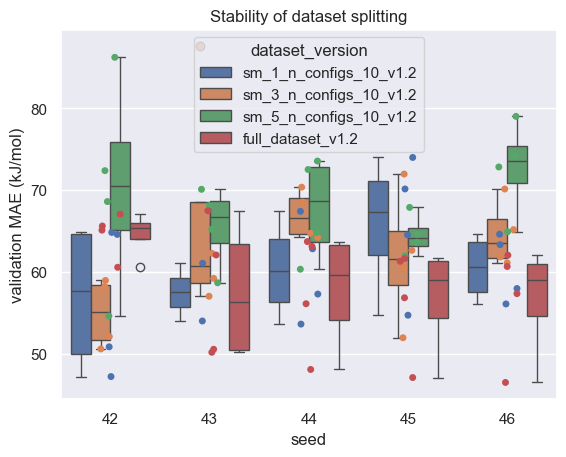

In [9]:
ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="val/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")

### Limit to a single spin multiplicity

In [10]:
results_single_spin = test_results_df[test_results_df["dataset_version"] != "full_dataset_v1.1"]

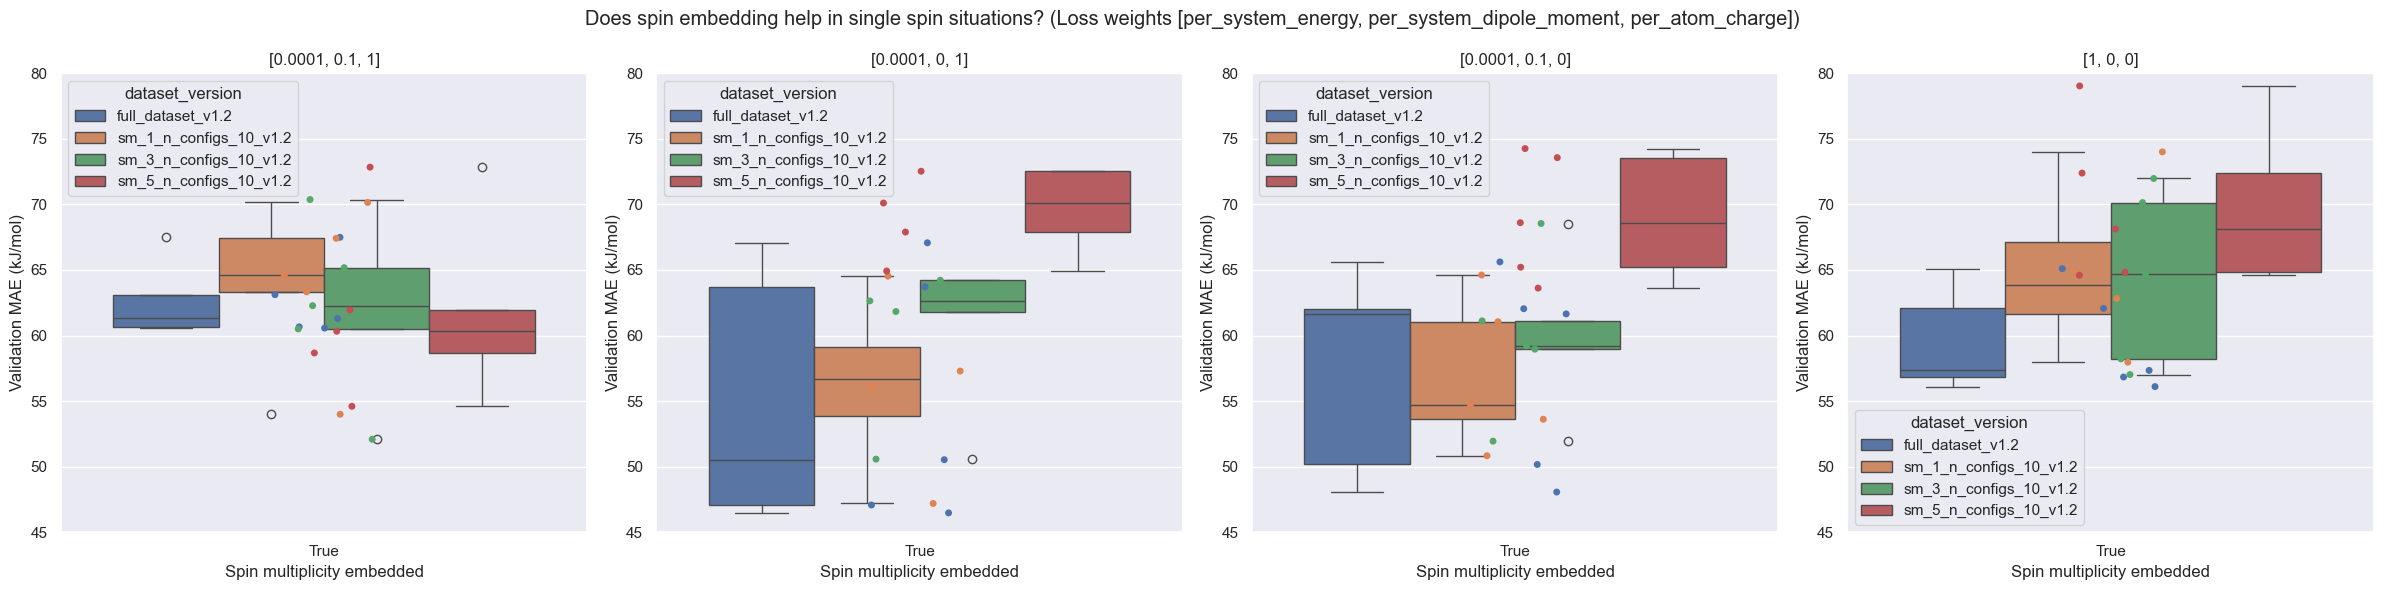

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in single spin situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_version_select = [
    "full_dataset_sm1_v1.1",
    "full_dataset_sm3_v1.1",
    "full_dataset_sm5_v1.1",
]

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_single_spin[
        # (results_single_spin["dataset_version"] == options_version_select[i]) &\
        (results_single_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_single_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_single_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
        hue="dataset_version",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        hue="dataset_version",
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Full dataset comparison

In [12]:
results_multi_spin = test_results_df[test_results_df["dataset_version"] == "full_dataset_v1.2"]

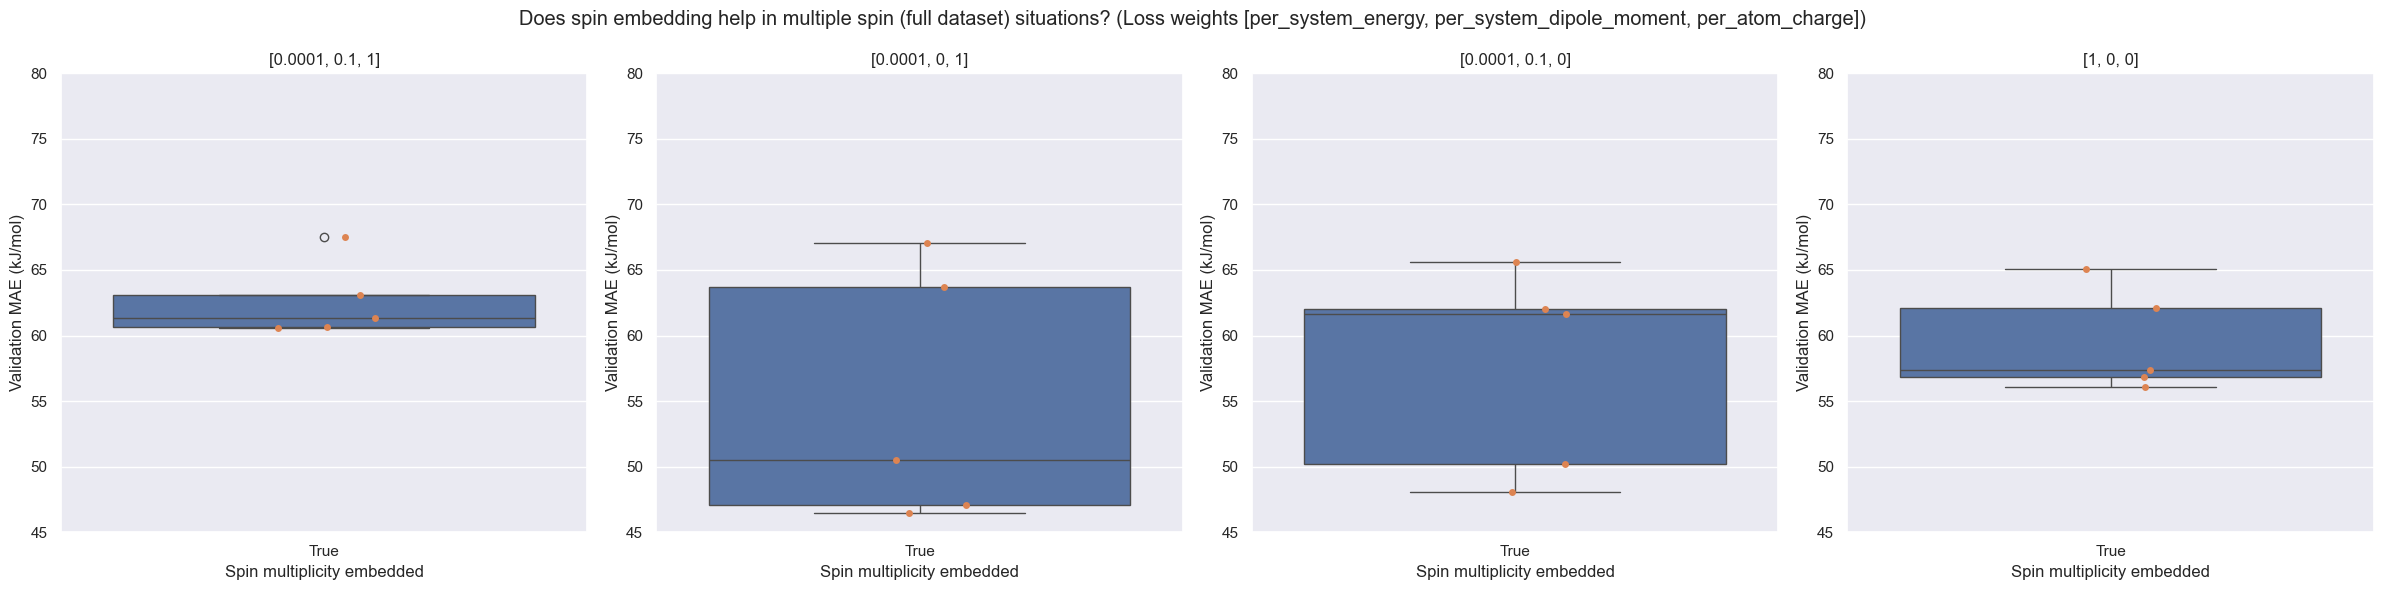

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in multiple spin (full dataset) situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Evalute with the fixed test dataset

In [14]:
from openff.units import unit


# Define the reference energies for each element in kJ/mol
ase = {
    "H": -1574.9057945240868 * unit.kilojoule_per_mole,
    "C": -100086.51170377462 * unit.kilojoule_per_mole,
    "N": -143801.51483853368 * unit.kilojoule_per_mole,
    "O": -197604.4180833407 * unit.kilojoule_per_mole,
    "F": -262248.6420523814 * unit.kilojoule_per_mole,
    "P": -896364.0735122316 * unit.kilojoule_per_mole,
    "S": -1045654.468887562 * unit.kilojoule_per_mole,
    "Cl": -1208514.2106607035 * unit.kilojoule_per_mole,
    "Fe": -3318371.4922360503 * unit.kilojoule_per_mole,
    "Cu": -4307496.132092452 * unit.kilojoule_per_mole,
    "Zn": -4672271.154058549 * unit.kilojoule_per_mole,
    "Br": -6759287.787427634 * unit.kilojoule_per_mole,
    "Pd": -335891.6546589908 * unit.kilojoule_per_mole,
}

# define the dataset statistics to use if the dataset was normalized

dataset_statistic = {
    "training_dataset_statistics": {
        "per_atom_energy_mean": -5.146267064064403,
        "per_atom_energy_stddev": 6.048297128174876,
    }
}

In [15]:
filename = "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/runs/run077/logs/aimnet2_tmqm_openff/bqftyw6v/checkpoints/best_AimNet2-tmqm_openff_local-epoch=67.ckpt"
potential = load_inference_model_from_checkpoint(filename, jit=False)
potential.to(device="cuda" if torch.cuda.is_available() else "cpu")

2025-08-24 21:16:35.304 | DEBUG    | modelforge.potential.potential:generate_potential:848 - training_parameter=None
2025-08-24 21:16:35.305 | DEBUG    | modelforge.potential.potential:generate_potential:849 - potential_parameter=AimNet2Parameters(potential_name='AimNet2', only_unique_pairs=False, core_parameter=CoreParameter(number_of_radial_basis_functions=64, maximum_interaction_radius=0.49999999999999994, number_of_interaction_modules=3, interaction_module_hidden_layers=[[512, 380], [512, 380], [512, 380, 380]], output_module_hidden_layers=[128, 128], activation_function_parameter=ActivationFunctionConfig(activation_function_name='GeLU', activation_function_arguments=None, activation_function=GELU(approximate='none')), featurization=Featurization(properties_to_featurize=['atomic_number', 'per_system_spin_state'], atomic_number=AtomicNumber(maximum_atomic_number=101, number_of_per_atom_features=128), atomic_period=AtomicPeriod(maximum_period=8, number_of_per_period_features=32), ato

Potential(
  (core_network): AimNet2Core(
    (activation_function): GELU(approximate='none')
    (representation_module): AIMNet2Representation(
      (radial_symmetry_function_module): SchnetRadialBasisFunction(
        (radial_basis_function): GaussianRadialBasisFunctionCore()
      )
      (featurize_input): FeaturizeInput(
        (append_to_embedding_tensor): ModuleList(
          (0): AddPerMoleculeValue()
        )
        (embeddings): ModuleList()
        (atomic_number_embedding): Embedding(101, 128)
        (mixing): DenseWithCustomDist(
          in_features=129, out_features=128, bias=True
          (activation_function): Identity()
        )
      )
      (cutoff_module): CosineAttenuationFunction()
    )
    (interaction_modules): ModuleList(
      (0): AIMNet2InteractionModule(
        (gs_to_fatom): Dense(
          in_features=64, out_features=128, bias=False
          (activation_function): Identity()
        )
        (mlp): Sequential(
          (0): Dense(
      

In [16]:
# if the dataset was normalized we need to unnormalize the energy
# to compare with the reference energies in the hdf5 dataset
unnormalize_energy = False

import h5py

# define the input file name of the hdf5 file that contains the fixed test subset
input_filename = "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5"

from tqdm import tqdm
from dataclasses import dataclass
from modelforge.dataset.utils import _ATOMIC_NUMBER_TO_ELEMENT
from modelforge.utils.prop import NNPInput

2025-08-24 21:16:35.356 | DEBUG    | modelforge.potential.potential:generate_potential:848 - training_parameter=None
2025-08-24 21:16:35.356 | DEBUG    | modelforge.potential.potential:generate_potential:849 - potential_parameter=AimNet2Parameters(potential_name='AimNet2', only_unique_pairs=False, core_parameter=CoreParameter(number_of_radial_basis_functions=64, maximum_interaction_radius=0.49999999999999994, number_of_interaction_modules=3, interaction_module_hidden_layers=[[512, 380], [512, 380], [512, 380, 380]], output_module_hidden_layers=[128, 128], activation_function_parameter=ActivationFunctionConfig(activation_function_name='GeLU', activation_function_arguments=None, activation_function=GELU(approximate='none')), featurization=Featurization(properties_to_featurize=['atomic_number', 'per_system_spin_state'], atomic_number=AtomicNumber(maximum_atomic_number=101, number_of_per_atom_features=128), atomic_period=AtomicPeriod(maximum_period=8, number_of_per_period_features=32), ato

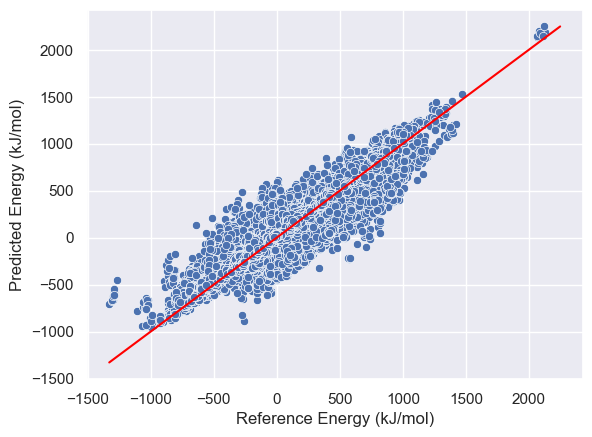

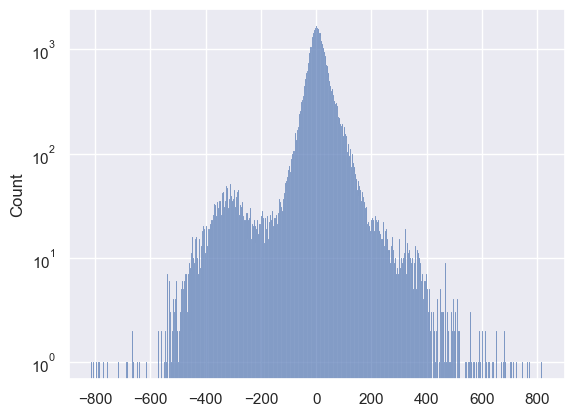

In [17]:
helper.test_nnp_with_fixed_tmqm_subset(
    "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/runs/run077/logs/aimnet2_tmqm_openff/bqftyw6v/checkpoints/best_AimNet2-tmqm_openff_local-epoch=67.ckpt",
    "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5",
    "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/runs/run077/test_results/"
)